### Macroeconomics PS6

- Notebook Author: Tao Wang
- twang80@jhu.edu
- [Original Homework](ps6.pdf)
- Codes adapted from [QuantEcon](https://lectures.quantecon.org/py/optgrowth.html)

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fminbound
%matplotlib inline  
from quantecon import compute_fixed_point

In [7]:
## Define bellman operator 
## Copied from QuantEcon  

def bellman_operator(w, grid, β, u, f, shocks, Tw=None, compute_policy=0):
    """
    The approximate Bellman operator, which computes and returns the
    updated value function Tw on the grid points.  An array to store
    the new set of values Tw is optionally supplied (to avoid having to
    allocate new arrays at each iteration).  If supplied, any existing data in 
    Tw will be overwritten.

    Parameters
    ----------
    w : array_like(float, ndim=1)
        The value of the input function on different grid points
    grid : array_like(float, ndim=1)
        The set of grid points
    β : scalar
        The discount factor
    u : function
        The utility function
    f : function
        The production function
    shocks : numpy array
        An array of draws from the shock, for Monte Carlo integration (to
        compute expectations).
    Tw : array_like(float, ndim=1) optional (default=None)
        Array to write output values to
    compute_policy : Boolean, optional (default=False)
        Whether or not to compute policy function

    """
    # === Apply linear interpolation to w === #
    w_func = lambda x: np.interp(x, grid, w)   # It returns values of w at x based on values of w at grids. 

    # == Initialize Tw if necessary == #
    if Tw is None:
        Tw = np.empty_like(w)   # Generate an empty array in the same size of w values.

    if compute_policy:
        σ = np.empty_like(w) 

    # == set Tw[i] = max_c { u(c) + β E w(f(y  - c) z)} == #
    for i, y in enumerate(grid):    # i and y are like two periods. 
        def objective(c):    
            return - u(c) - β * np.mean(w_func(f(y - c) * shocks))
        c_star = fminbound(objective, 1e-10, y)
        if compute_policy:
            σ[i] = c_star
        Tw[i] = - objective(c_star)

    if compute_policy:
        return Tw, σ
    else:
        return Tw

### An Example on Bellman Operator 

- $u(c) = ln c$
- $f(k,z) = z k^\alpha$
- $\zeta$ is standard log-normal and the distribution of $e^{\mu+\alpha\zeta}$ is $\phi$

In [8]:
#Copied from QuantEcon

class LogLinearOG:
    """
    Log linear optimal growth model, with log utility, CD production and
    multiplicative lognormal shock, so that

        y = f(k, z) = z k^α

    with z ~ LN(μ, s).

    The class holds parameters and true value and policy functions.
    """

    def __init__(self, α=0.4, β=0.96, μ=0, s=0.1):

        self.α, self.β, self.μ, self.s = α, β, μ, s 

        # == Some useful constants == #
        self.ab = α * β
        self.c1 = np.log(1 - self.ab) / (1 - β)
        self.c2 = (μ + α * np.log(self.ab)) / (1 - α)
        self.c3 = 1 / (1 - β)
        self.c4 = 1 / (1 - self.ab)

    def u(self, c):
        " Utility "
        return np.log(c)

    def u_prime(self, c):
        return 1 / c

    def f(self, k):
        " Deterministic part of production function.  "
        return k**self.α

    def f_prime(self, k):
        return self.α * k**(self.α - 1)

    def c_star(self, y):
        " True optimal policy.  "
        return (1 - self.α * self.β) * y

    def v_star(self, y):
        " True value function. "
        return self.c1 + self.c2 * (self.c3 - self.c4) + self.c4 * np.log(y)

In [9]:
## Set parameters

lg = LogLinearOG()
# == Unpack parameters / functions for convenience == #
α, β, μ, s = lg.α, lg.β, lg.μ, lg.s
v_star = lg.v_star

grid_max = 4         # Largest grid point
grid_size = 200      # Number of grid points
shock_size = 250     # Number of shock draws in Monte Carlo integral

grid = np.linspace(1e-5, grid_max, grid_size)
shocks = np.exp(μ + s * np.random.randn(shock_size))

w = bellman_operator(v_star(grid),
                     grid,
                     β,
                     np.log,
                     lambda k: k**α,
                     shocks)


In [10]:
s = 0.05
shocks = np.exp(μ + s * np.random.randn(shock_size))

In [11]:
## Modified the simulate_og function to return not only series of income, but also capital stock.
## Copied from QuantEcon

def simulate_og_k(σ, y0 = 0.1, ts_length=100):
    '''
    Compute both time series of output and capital stock given consumption policy σ.
    '''
    y = np.empty(ts_length)
    cap = np.empty(ts_length)
    ξ = np.random.randn(ts_length-1)
    y[0] = y0
    for t in range(ts_length-1):
        cap[t] = y[t] - σ(y[t])  
        y[t+1] = (y[t] - σ(y[t]))**α * np.exp(μ + s * ξ[t])
    return y,cap

In [12]:
def simulate_og(σ, y0 = 0.1, ts_length=100):
    '''
    Compute a time series given consumption policy σ.
    '''
    y = np.empty(ts_length)
    ξ = np.random.randn(ts_length-1)
    y[0] = y0
    for t in range(ts_length-1):
        y[t+1] = (y[t] - σ(y[t]))**α * np.exp(μ + s * ξ[t])
    return y

### Different Time Preference

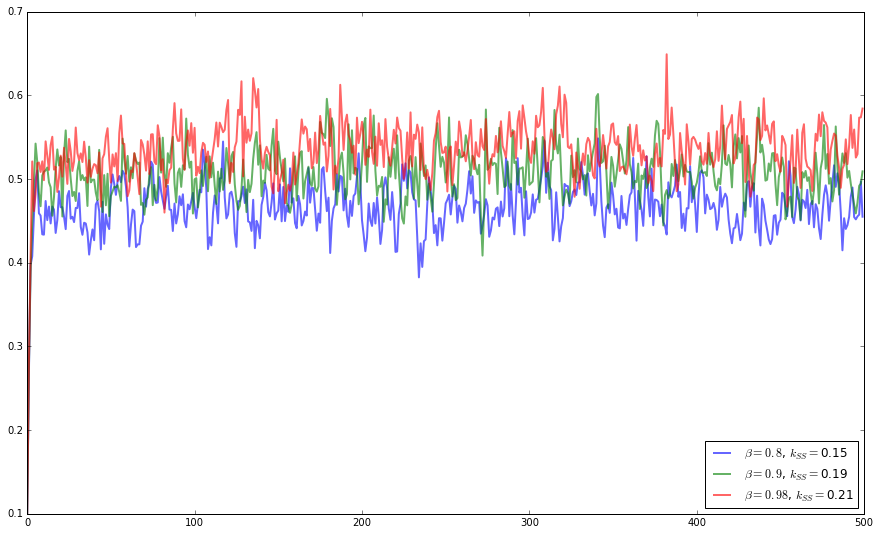

In [13]:
fig, ax = plt.subplots(figsize=(15, 9))

for β in (0.8, 0.9, 0.98):

    Tw = np.empty(len(grid))
    initial_w = 5 * np.log(grid)
    period = 500

    v_star_approx = compute_fixed_point(bellman_operator,
                                        initial_w,
                                        1e-5,        # error_tol
                                        period,      # max_iter
                                        False,       # verbose
                                        5,           # print_skip
                                        grid,
                                        β,
                                        np.log,
                                        lambda k: k**α,
                                        shocks,
                                        Tw=Tw,
                                        compute_policy=False)

    Tw, σ = bellman_operator(v_star_approx,
                             grid,
                             β,
                             np.log,
                             lambda k: k**α,
                             shocks,
                             compute_policy=True)

    σ_func = lambda x: np.interp(x, grid, σ)
    y,k = simulate_og_k(σ_func,ts_length=period)   # with capital stock
    k_ss = np.average(k[200:,])   # steady state capital: average of 200 periods onward 
    ax.plot(y, lw=2, alpha=0.6, label=r'$\beta = {}$'.format(β)+', '+r'$k_{SS}=$'+str(round(k_ss,2)))


ax.legend(loc='lower right')

### Different Capital Share 

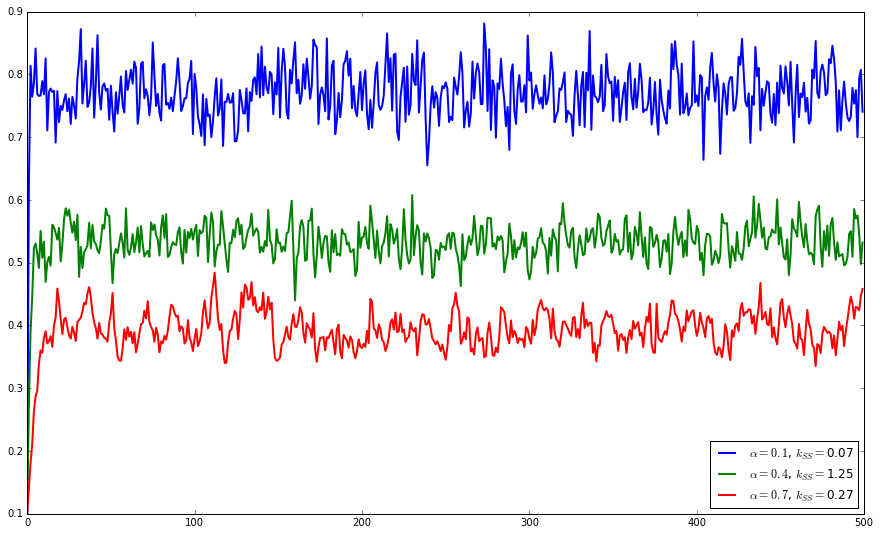

In [14]:
fig, ax = plt.subplots(figsize=(15, 9))

β =0.96

for α in (0.1, 0.4, 0.7):

    Tw = np.empty(len(grid))
    initial_w = 5 * np.log(grid)
    period = 500


    v_star_approx = compute_fixed_point(bellman_operator,
                                        initial_w,
                                        1e-5,        # error_tol
                                        period,      # max_iter
                                        False,       # verbose
                                        5,           # print_skip
                                        grid,
                                        β,
                                        np.log,
                                        lambda k: k**α,
                                        shocks,
                                        Tw=Tw,
                                        compute_policy=False)

    Tw, σ = bellman_operator(v_star_approx,
                             grid,
                             β,
                             np.log,
                             lambda k: k**α,
                             shocks,
                             compute_policy=True)

    σ_func = lambda x: np.interp(x, grid, σ)
    y,k = simulate_og_k(σ_func,ts_length=period)   # with capital stock 
    k_ss = np.average(k[200:,])        # steady state capital: average of 200 periods onward 
    ax.plot(y, lw=2, label=r'$\alpha= {}$'.format(α)+', '+r'$k_{SS}=$'+str(round(k_ss,2)))


ax.legend(loc='lower right')

### Different Risk Aversion 

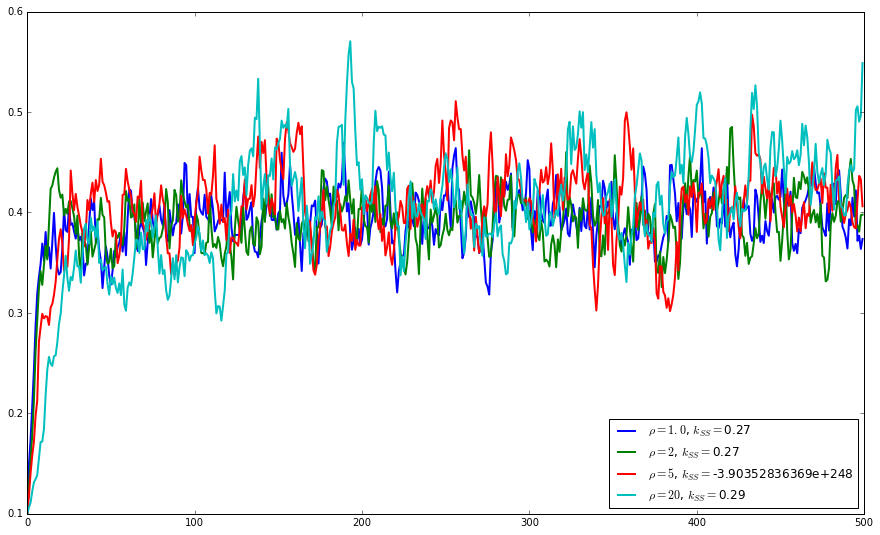

In [15]:
fig, ax = plt.subplots(figsize=(15, 9))

for rho in (1.01, 2, 5, 20):
    
    def crra(c):
        return c**(1-rho)/(1-rho)  # CRRA Utility

    Tw = np.empty(len(grid))

    initial_w = 5 * crra(grid)
    
    period = 500

    v_star_approx = compute_fixed_point(bellman_operator,
                                        initial_w,
                                        1e-5,        # error_tol
                                        period,         # max_iter
                                        False,       # verbose
                                        5,           # print_skip
                                        grid,
                                        β,
                                        crra,    # replace with CRRA utility now
                                        lambda k: k**α,
                                        shocks,
                                        Tw=Tw,
                                        compute_policy=False)

    Tw, σ = bellman_operator(v_star_approx,
                             grid,
                             β,
                             crra,
                             lambda k: k**α,
                             shocks,
                             compute_policy=True)

    σ_func = lambda x: np.interp(x, grid, σ)
    y,k = simulate_og_k(σ_func,ts_length=period)   # with capital stock
    k_ss = np.average(k[200:,])     # steady state capital: average of 200 periods onward 
    ax.plot(y, lw=2, label=r'$\rho= {}$'.format(round(rho,0))+', '+r'$k_{SS}=$'+str(round(k_ss,2)))

ax.legend(loc='lower right')